In [17]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
from folium import plugins
from folium import FeatureGroup
from config import vworld_key
import json
import math
import re
from datetime import datetime
import os
import glob
import subprocess
from bs4 import BeautifulSoup as bs
from shapely.geometry import Point, Polygon, LineString
import geopandas as gpd
from geopandas import GeoSeries
import pyproj

# 모든 열이 생략되지 않도록 설정
pd.set_option('display.max_columns', None)

In [2]:
# 폴리곤을 만드는 함수
def make_geo(x):
    try:
        return Polygon(x[0])
    except:
        return Polygon(x[0][0])

In [10]:
# 데이터프레임을 GeoPandas 데이터프레임으로 변환하는 함수 정의
def geo_transform(DataFrame) :
    # csv to geopandas
    # lon, lat data를 geometry로 변경
    DataFrame['lat'] = DataFrame['lat'].astype(float)
    DataFrame['lon'] = DataFrame['lon'].astype(float)
    DataFrame['geometry'] = DataFrame.apply(lambda row : Point([row['lon'], row['lat']]), axis=1) # 위도 및 경도롤 GeoPandas Point 객체로 변환
    DataFrame = gpd.GeoDataFrame(DataFrame, geometry='geometry')
    DataFrame.crs = {'init':'epsg:4326'} # geopandas 데이터프레임의 좌표계를 EPSG 4326으로 설정
    DataFrame = DataFrame.to_crs({'init':'epsg:4326'}) # 데이터프레임의 좌표계를 자체 좌표계에서 EPSG 4326으로 변환
    return DataFrame

### 청주시_도시재생계획구역

In [29]:
# GeoJSON 파일 불러오기
with open('SBJ_2309_001/27.청주시_도시재생계획구역.geojson') as geojson_file:
    geojson_data = json.load(geojson_file)
crp_df = pd.json_normalize(geojson_data) # city_revitalize_planning_map_df
crp_df['geometry'] = crp_df['geometry.coordinates'].apply(lambda x : make_geo(x))
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)

# 폴리곤의 중점을 찾음
centroid = crp_df['geometry'].iloc[0].centroid.buffer(0.015) # 1도의 위도 변화는 대략 111.32 킬로미터
crp_df['centroid_polygon_geometry'] = [centroid]
crp_df

,type,properties.fid,properties.구역명,geometry.type,geometry.coordinates,geometry,centroid_polygon_geometry
0,Feature,5,도시재생구역도,Polygon,"[[[127.4833417, 36.6318644], [127.4833417, 36....","POLYGON ((127.4833417 36.6318644, 127.4833417 ...",POLYGON ((127.50347965416363 36.63603755594320...


In [ ]:
# 지도의 중심 좌표 설정
m = folium.Map(location=[36.60720970472786, 127.63641867895493], zoom_start=12)

# GeoDataFrame을 순회하면서 Polygon을 지도에 추가
for idx, row in crp_df.iterrows():
    popup_text = f"{row['properties.구역명']}"
    folium.GeoJson(
        row['centroid_polygon_geometry'].__geo_interface__,
        style_function=lambda feature, color='blue': {'fillColor': 'blue', 'color': 'black', 'weight': 0.1}
    ).add_to(m).add_child(folium.Popup(popup_text, max_width=100))  # 팝업 메시지 추가
    
m

### 격자(매핑용)

In [ ]:
# GeoJSON 파일 불러오기
with open('SBJ_2309_001/26.청주시_격자(매핑용).geojson') as geojson_file:
    geojson_data = json.load(geojson_file)
grid_map_df = pd.json_normalize(geojson_data['features'])
grid_map_df['geometry'] = grid_map_df['geometry.coordinates'].apply(lambda x : make_geo(x))
grid_map_df

In [31]:
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0].centroid.buffer(0.01)

# grid_map_df 데이터프레임을 GeoDataFrame으로 변환
grid_map_df = gpd.GeoDataFrame(grid_map_df, geometry='geometry')
#grid_map_df['geometry'] = GeoSeries(grid_map_df['geometry'])

# factory_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_grid = grid_map_df[grid_map_df['geometry'].within(polygon)].reset_index(drop=True)

In [ ]:
# 지도의 중심 좌표 설정
m = folium.Map(location=[36.60720970472786, 127.63641867895493], zoom_start=12)

# GeoDataFrame을 순회하면서 Polygon을 지도에 추가
for idx, row in filtered_grid.iterrows():
    popup_text = f"{row['properties.gid']}"
    folium.GeoJson(
        row['geometry'].__geo_interface__,
        style_function=lambda feature, color='black': {'fillColor': 'black', 'color': 'black', 'weight': 0.1}
    ).add_to(m).add_child(folium.Popup(popup_text, max_width=100))  # 팝업 메시지 추가
    
m

### 거주인구 격자에 매핑

In [ ]:
pd.read_csv('SBJ_2309_001/1.청주시_거주인구.csv')

In [ ]:
pd.read_csv('SBJ_2309_001/2.청주시_성연령별_유동인구.csv')

### 청주시 폐공장현황

In [ ]:
factory_df = pd.read_csv('SBJ_2309_001/9.청주시_폐공장현황.csv')
factory_df

In [11]:
# 데이터프레임을 GeoPandas 데이터프레임으로 변환
factory_df = geo_transform(factory_df)

# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]

# factory_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_factory = factory_df[factory_df['geometry'].within(polygon)]

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
from folium.plugins import MarkerCluster
# Folium 지도 생성
m = folium.Map(location=[36.627797, 127.511943], zoom_start=13, width='100%', height='100%')

# 배경지도 타일 설정하기
layer = "Hybrid"
tileType = "png"
tiles = f"http://api.vworld.kr/req/wmts/1.0.0/{vworld_key}/{layer}/{{z}}/{{y}}/{{x}}.{tileType}"
attr = "Vworld"

folium.TileLayer(
    tiles=tiles,
    attr=attr,
    overlay=True,
    control=True
).add_to(m)

# GeoJSON 데이터를 지도에 추가
for index, row in filtered_points_factory.iterrows():
    marker = folium.CircleMarker(
        location=[row['geometry'].y, row['geometry'].x],
        radius=5,
        fill=True,
    )
    marker.add_to(m)

# 지도 저장
m

### 청주시 문화재 현황 (폴리곤 영역확장 변경으로 교통분석 후 문화재 필터링 해야할 듯)

In [ ]:
culture_assets_df = pd.read_csv('SBJ_2309_001/5.청주시_유적지_문화재현황.csv')
culture_assets_df

In [82]:
# 데이터프레임을 GeoPandas 데이터프레임으로 변환
culture_assets_df = geo_transform(culture_assets_df)

# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]

# 폴리곤을 확장 (예: 0.1 도 또는 10 킬로미터 확장)
expanded_polygon = polygon.buffer(0.015)  # 0.015은 확장할 크기. EPSG 4326 좌표계에서는 위도 및 경도가 0.015도씩 확장됨.(약 1.7km 나중에 변경 될 수 있음)

# factory_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_culture = culture_assets_df[culture_assets_df['geometry'].within(expanded_polygon)].reset_index(drop=True)

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
filtered_points_culture

In [ ]:
from folium.plugins import MarkerCluster
# Folium 지도 생성
m = folium.Map(location=[36.627797, 127.511943], zoom_start=13, width='100%', height='100%')

# 배경지도 타일 설정하기
layer = "Hybrid"
tileType = "png"
tiles = f"http://api.vworld.kr/req/wmts/1.0.0/{vworld_key}/{layer}/{{z}}/{{y}}/{{x}}.{tileType}"
attr = "Vworld"

folium.TileLayer(
    tiles=tiles,
    attr=attr,
    overlay=True,
    control=True
).add_to(m)

# GeoJSON 데이터를 지도에 추가
for index, row in filtered_points_culture.iterrows():
    marker = folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        fill=True,
    )
    marker.add_to(m)

# 지도 저장
m

### 청주시 시장 현황 (폴리곤 영역확장 없이 범위 내 시장들만 필터링)

In [108]:
market_df = pd.read_csv('SBJ_2309_001/6.청주시_시장현황.csv')
market_df

,market_nm,addr,area,lon,lat
0,육거리종합시장,상당구 청남로2197번길 42(석교동),86273,127.488184,36.627938
1,서문시장,상당구 남사로89번길 57(서문동),10285,127.485365,36.634894
2,중앙시장,상당구 중앙로 26(북문로2가),7305,127.489192,36.639385
3,사직시장,서원구 사직대로265번길 7(사직동),9200,127.476868,36.636143
4,북부시장,청원구 향군로31번길 19(우암동),22133,127.486221,36.647973


In [109]:
# 데이터프레임을 GeoPandas 데이터프레임으로 변환
market_df = geo_transform(market_df)

# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]

# factory_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_market = market_df[market_df['geometry'].within(polygon)].reset_index(drop=True)

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [110]:
filtered_points_market

,market_nm,addr,area,lon,lat,geometry
0,육거리종합시장,상당구 청남로2197번길 42(석교동),86273,127.488184,36.627938,POINT (127.48818 36.62794)
1,서문시장,상당구 남사로89번길 57(서문동),10285,127.485365,36.634894,POINT (127.48536 36.63489)
2,중앙시장,상당구 중앙로 26(북문로2가),7305,127.489192,36.639385,POINT (127.48919 36.63938)


In [ ]:
from folium.plugins import MarkerCluster
# Folium 지도 생성
m = folium.Map(location=[36.627797, 127.511943], zoom_start=13, width='100%', height='100%')

# 배경지도 타일 설정하기
layer = "Hybrid"
tileType = "png"
tiles = f"http://api.vworld.kr/req/wmts/1.0.0/{vworld_key}/{layer}/{{z}}/{{y}}/{{x}}.{tileType}"
attr = "Vworld"

folium.TileLayer(
    tiles=tiles,
    attr=attr,
    overlay=True,
    control=True
).add_to(m)

# GeoJSON 데이터를 지도에 추가
for index, row in filtered_points_market.iterrows():
    marker = folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        fill=True,
    )
    marker.add_to(m)

# 지도 저장
m

### 청주시 주차장 현황 (폴리곤 영역확장 고민해봐야 할듯)

In [ ]:
parking_df = pd.read_csv('SBJ_2309_001/7.청주시_주차장현황.csv')
parking_df

In [ ]:
# 데이터프레임을 GeoPandas 데이터프레임으로 변환
parking_df = geo_transform(parking_df)

# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0] # 또는 centroid_polygon_geometry

# factory_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_parking = parking_df[parking_df['geometry'].within(polygon)].reset_index(drop=True)

In [ ]:
filtered_points_parking # 노상 : 도로 위 한켠에 주차를 하고 일정 비용을 받음(정부 또는 지자체 관할), 노외 : 공용주차장처럼 별도 대지에 설치되어 제공되는 주차장

In [ ]:
from folium.plugins import MarkerCluster
# Folium 지도 생성
m = folium.Map(location=[36.627797, 127.511943], zoom_start=13, width='100%', height='100%')

# 배경지도 타일 설정하기
layer = "Hybrid"
tileType = "png"
tiles = f"http://api.vworld.kr/req/wmts/1.0.0/{vworld_key}/{layer}/{{z}}/{{y}}/{{x}}.{tileType}"
attr = "Vworld"

folium.TileLayer(
    tiles=tiles,
    attr=attr,
    overlay=True,
    control=True
).add_to(m)

# GeoJSON 데이터를 지도에 추가
for index, row in filtered_points_parking.iterrows():
    marker = folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        fill=True,
    )
    marker.add_to(m)

# 지도 저장
m

### 청주시 공원 현황 (폴리곤 영역확장 고민해봐야 할듯)

In [ ]:
park_df = pd.read_csv('SBJ_2309_001/8.청주시_공원현황.csv')
park_df

In [ ]:
# 데이터프레임을 GeoPandas 데이터프레임으로 변환
park_df = geo_transform(park_df)

# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0] # 또는 centroid_polygon_geometry

# factory_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_park = park_df[park_df['geometry'].within(polygon)].reset_index(drop=True)

In [ ]:
filtered_points_park

In [ ]:
from folium.plugins import MarkerCluster
# Folium 지도 생성
m = folium.Map(location=[36.627797, 127.511943], zoom_start=13, width='100%', height='100%')

# 배경지도 타일 설정하기
layer = "Hybrid"
tileType = "png"
tiles = f"http://api.vworld.kr/req/wmts/1.0.0/{vworld_key}/{layer}/{{z}}/{{y}}/{{x}}.{tileType}"
attr = "Vworld"

folium.TileLayer(
    tiles=tiles,
    attr=attr,
    overlay=True,
    control=True
).add_to(m)

# GeoJSON 데이터를 지도에 추가
for index, row in filtered_points_park.iterrows():
    marker = folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        fill=True,
    )
    marker.add_to(m)

# 지도 저장
m

### 청주시 학교 현황

In [ ]:
school_df = pd.read_csv('SBJ_2309_001/24.청주시_학교현황.csv')
school_df

In [128]:
# 데이터프레임을 GeoPandas 데이터프레임으로 변환
school_df = geo_transform(school_df)

# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0] # 또는 centroid_polygon_geometry

# factory_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_school = school_df[school_df['geometry'].within(polygon)].reset_index(drop=True)

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
filtered_points_school

In [ ]:
from folium.plugins import MarkerCluster
# Folium 지도 생성
m = folium.Map(location=[36.627797, 127.511943], zoom_start=13, width='100%', height='100%')

# 배경지도 타일 설정하기
layer = "Hybrid"
tileType = "png"
tiles = f"http://api.vworld.kr/req/wmts/1.0.0/{vworld_key}/{layer}/{{z}}/{{y}}/{{x}}.{tileType}"
attr = "Vworld"

folium.TileLayer(
    tiles=tiles,
    attr=attr,
    overlay=True,
    control=True
).add_to(m)

# GeoJSON 데이터를 지도에 추가
for index, row in filtered_points_school.iterrows():
    marker = folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        fill=True,
    )
    marker.add_to(m)

# 지도 저장
m

### 청주시 어린이집 유치원 현황

In [ ]:
kinder_df = pd.read_csv('SBJ_2309_001/28.청주시_어린이집_유치원현황.csv')
kinder_df

In [ ]:
# 데이터프레임을 GeoPandas 데이터프레임으로 변환
kinder_df = geo_transform(kinder_df)

# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0] # 또는 centroid_polygon_geometry

# factory_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_kinder = kinder_df[kinder_df['geometry'].within(polygon)].reset_index(drop=True)

In [ ]:
filtered_points_kinder

In [ ]:
from folium.plugins import MarkerCluster
# Folium 지도 생성
m = folium.Map(location=[36.627797, 127.511943], zoom_start=13, width='100%', height='100%')

# 배경지도 타일 설정하기
layer = "Hybrid"
tileType = "png"
tiles = f"http://api.vworld.kr/req/wmts/1.0.0/{vworld_key}/{layer}/{{z}}/{{y}}/{{x}}.{tileType}"
attr = "Vworld"

folium.TileLayer(
    tiles=tiles,
    attr=attr,
    overlay=True,
    control=True
).add_to(m)

# GeoJSON 데이터를 지도에 추가
for index, row in filtered_points_kinder.iterrows():
    marker = folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        fill=True,
    )
    marker.add_to(m)

# 지도 저장
m

### 청주시 가로수 현황 (공공데이터포털 - 산림청_도시숲가로수관리 가로수 현황 data https://www.data.go.kr/data/15120900/fileData.do)

In [ ]:
'''산림청_도시숲가로수관리 가로수 현황_20221231 데이터 정제 완료 -'''
# street_tree_df = pd.read_csv('SBJ_2309_001/산림청_도시숲가로수관리 가로수 현황_20221231.csv', encoding='cp949')
# street_tree_df = street_tree_df[['시군구명', '도로구간명', '수종명', '지역X좌표', '지역Y좌표']]
# street_tree_df = street_tree_df[street_tree_df['시군구명'].str.contains('청주')].reset_index(drop=True)

# # EPSG 5186에서 EPSG 4326으로 좌표 변환을 수행하는 함수 생성
# def transform_coordinates(row):
#     in_proj = pyproj.Proj(init='epsg:5186')
#     out_proj = pyproj.Proj(init='epsg:4326')
#     lon, lat = pyproj.transform(in_proj, out_proj, row['지역X좌표'], row['지역Y좌표'])
#     return pd.Series({'lat': lat, 'lon': lon})

# # '지역X좌표'와 '지역Y좌표'를 EPSG 4326으로 변환하고 'lat' 및 'lon' 열로 이름 변경
# street_tree_df[['lat', 'lon']] = street_tree_df.apply(transform_coordinates, axis=1)
# # '지역X좌표'와 '지역Y좌표' 열을 삭제 (선택 사항)
# street_tree_df.drop(['지역X좌표', '지역Y좌표'], axis=1, inplace=True)

# 

In [42]:
street_tree_df = pd.read_csv('SBJ_2309_001/29.청주시_가로수현황.csv', encoding='UTF8')
street_tree_df

,시군구명,도로구간명,수종명,lat,lon
0,충청북도 청주시 청원구,오창대로,벚나무,36.708975,127.481089
1,충청북도 청주시 청원구,오창대로,벚나무,36.708883,127.480707
2,충청북도 청주시 청원구,오창대로,벚나무,36.708996,127.481787
3,충청북도 청주시 청원구,오창대로,벚나무,36.708625,127.480314
4,충청북도 청주시 청원구,오창대로,벚나무,36.708993,127.481158
...,...,...,...,...,...
24481,충청북도 청주시 청원구,율중로29번길,이팝나무,36.660599,127.507634
24482,충청북도 청주시 청원구,율중로29번길,이팝나무,36.660668,127.507612
24483,충청북도 청주시 청원구,율중로29번길,이팝나무,36.660737,127.507589
24484,충청북도 청주시 청원구,율중로29번길,이팝나무,36.660249,127.507748


In [44]:
# 데이터프레임을 GeoPandas 데이터프레임으로 변환
street_tree_df = geo_transform(street_tree_df)

# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0] # 또는 centroid_polygon_geometry

# factory_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_tree = street_tree_df[street_tree_df['geometry'].within(polygon)].reset_index(drop=True)

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
filtered_points_tree

In [ ]:
from folium.plugins import MarkerCluster
# Folium 지도 생성
m = folium.Map(location=[36.627797, 127.511943], zoom_start=13, width='100%', height='100%')

# 배경지도 타일 설정하기
layer = "Hybrid"
tileType = "png"
tiles = f"http://api.vworld.kr/req/wmts/1.0.0/{vworld_key}/{layer}/{{z}}/{{y}}/{{x}}.{tileType}"
attr = "Vworld"

folium.TileLayer(
    tiles=tiles,
    attr=attr,
    overlay=True,
    control=True
).add_to(m)

# GeoJSON 데이터를 지도에 추가
for index, row in filtered_points_tree.iterrows():
    marker = folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        fill=True,
    )
    marker.add_to(m)

# 지도 저장
m

### 청주시 상세 도로망 시각화

In [ ]:
# GeoJSON 파일 불러오기
with open('SBJ_2309_001/13.청주시_상세도로망.geojson', 'r') as geojson_file:
    geojson_data = json.load(geojson_file)
roadsystem_df = pd.json_normalize(geojson_data['features'])
roadsystem_df['geometry'] = roadsystem_df['geometry.coordinates'].apply(lambda x : LineString(x))
# roadsystem_df 데이터프레임을 GeoDataFrame으로 변환
roadsystem_df = gpd.GeoDataFrame(roadsystem_df, geometry='geometry')

In [ ]:
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0].centroid.buffer(0.02) # 또는 centroid_polygon_geometry

# factory_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_roadsystem = roadsystem_df[roadsystem_df['geometry'].within(polygon)].reset_index(drop=True)
filtered_roadsystem

In [ ]:
# 지도의 중심 좌표 설정
m = folium.Map(location=[36.627797, 127.511943], zoom_start=12)

# GeoDataFrame을 순회하면서 Polygon을 지도에 추가
for idx, row in filtered_roadsystem.iterrows():
    folium.GeoJson(
        row['geometry'].__geo_interface__,
        style_function=lambda feature, color='black': {'color': 'black', 'weight': 1}
    ).add_to(m)
    
m

### 청주시 불법주정차

In [ ]:
illegal_parking_df = pd.read_csv('SBJ_2309_001/14.청주시_불법주정차단속통계.csv')
illegal_parking_df = geo_transform(illegal_parking_df)
illegal_parking_df

In [ ]:
# map 생성
m = folium.Map(location=[36.627797, 127.511943],  zoom_start=12)

# 배경지도 타일 설정하기
layer = "Hybrid"
tileType = "png"
tiles = f"http://api.vworld.kr/req/wmts/1.0.0/{vworld_key}/{layer}/{{z}}/{{y}}/{{x}}.{tileType}"
attr = "Vworld"

folium.TileLayer(
    tiles=tiles,
    attr=attr,
    overlay=True,
    control=True
).add_to(m)

for _, row in illegal_parking_df.iterrows() :
    popup_text = f"{row['cd_loc']}({row['cd_dong']} - {row['cd_cnt']}건)"
    folium.Circle(location=(row['lat'], row['lon']), radius=30, color='#FF580B',
            fill='#FF580B').add_to(m).add_child(folium.Popup(popup_text, max_width=200))
    
m

### 청주시 112신고 통계 (격자매핑 형식)

In [118]:
police_report_df = pd.read_csv('SBJ_2309_001/20.청주시_112신고통계.csv')
# 5개년 신고건수 총합
police_report_df['repo_total'] = police_report_df['repo_2018'] + police_report_df['repo_2019'] + police_report_df['repo_2020'] + police_report_df['repo_2021'] + police_report_df['repo_2022']
police_report_df['repo_total'] = police_report_df['repo_total'].astype(int)
police_report_df = police_report_df[['gid', 'repo_total']]

#원도심 영역 grid id 리스트 로드 및 police_report_df 필터링
grid_id = filtered_grid['properties.gid'].tolist()
filtered_police_report = police_report_df[police_report_df['gid'].isin(grid_id)]
filtered_police_report['geometry'] = filtered_grid['geometry'].tolist()
filtered_police_report.sort_values(by='repo_total', ascending=False, inplace=True)
filtered_police_report.reset_index(drop=True, inplace=True)
filtered_police_report

C:\Users\user\AppData\Local\Temp\ipykernel_16180\1370399623.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_police_report['geometry'] = filtered_grid['geometry'].tolist()
C:\Users\user\AppData\Local\Temp\ipykernel_16180\1370399623.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_police_report.sort_values(by='repo_total', ascending=False, inplace=True)


,gid,repo_total,geometry
0,다바989482,1519,POLYGON ((127.48769621544852 36.63168220843648...
1,다바988483,1510,"POLYGON ((127.4865775332584 36.63258358652596,..."
2,다바992477,1406,POLYGON ((127.49105231410148 36.62717501134686...
3,다바991478,953,POLYGON ((127.48993373614363 36.62807642164767...
4,다바990486,887,POLYGON ((127.4888142201003 36.635288313298695...
...,...,...,...
268,다바994489,2,"POLYGON ((127.49328829744827 36.637993143918, ..."
269,다바996484,2,POLYGON ((127.49552579225157 36.63348575733207...
270,다바984494,2,POLYGON ((127.48210108412849 36.64249947656094...
271,다바995485,1,POLYGON ((127.49440717516781 36.63438720867091...


#### 경찰신고수는 평균에 대해 얼마나 높은가를 구해서 시각화 해야할듯...?

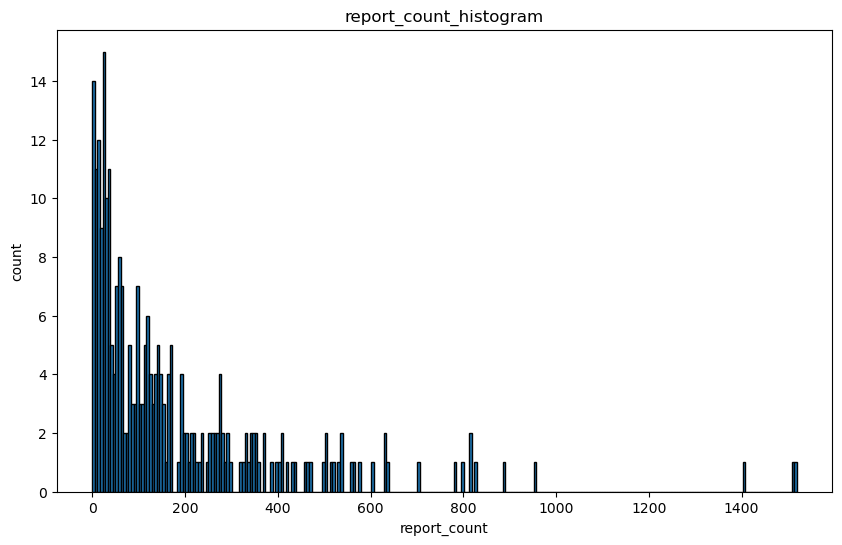

In [140]:
import pandas as pd
import matplotlib.pyplot as plt

lst = filtered_police_report['repo_total'].tolist()

# 빈도수의 히스토그램 그리기
plt.figure(figsize=(10, 6))  # 가로 10, 세로 6 크기의 그림 생성
plt.hist(lst, bins=len(lst), edgecolor='k')  # 'bins'는 히스토그램 막대의 개수를 조절합니다
plt.xlabel('report_count')
plt.ylabel('count')
plt.title('report_count_histogram')

# 히스토그램 표시
plt.show()


In [147]:
# map 생성
m = folium.Map(location=[36.627797, 127.511943],  zoom_start=12)

# 배경지도 타일 설정하기
layer = "Hybrid"
tileType = "png"
tiles = f"http://api.vworld.kr/req/wmts/1.0.0/{vworld_key}/{layer}/{{z}}/{{y}}/{{x}}.{tileType}"
attr = "Vworld"

folium.TileLayer(
    tiles=tiles,
    attr=attr,
    overlay=True,
    control=True
).add_to(m)

# 신고건수에 따라 색상을 지정하는 함수
def color_producer(repo_total):
    if repo_total < 300:
        return 'green'
    elif 300 <= repo_total < 800:
        return 'yellow'
    else:
        return 'red'
        
for _, row in filtered_police_report.iterrows() :
    popup_text = f"격자:{row['gid']}(신고건수 - {row['repo_total']}건)"
    color = color_producer(row['repo_total'])
    folium.GeoJson(
        row['geometry'].__geo_interface__,
        style_function=lambda feature, color=color: {
            'fillColor': color,
            'color': 'black',
            'weight': 0.2}
    ).add_to(m).add_child(folium.Popup(popup_text, max_width=100))
m

### 토지피복현황도

In [ ]:
# GeoJSON 파일 불러오기
with open('dataset/6.안산시_토지피복현황도.geojson', 'r') as geojson_file:
    geojson_data = json.load(geojson_file)
land_cover_df = pd.json_normalize(geojson_data['features'])
land_cover_df['geometry'] = land_cover_df['geometry.coordinates'].apply(lambda x : Polygon(x[0][0]))
land_cover_df['properties.피복-대분류'] = land_cover_df['properties.피복-대분류'].apply(lambda x : x.split('. ')[1])
land_cover_df['properties.피복-중분류'] = land_cover_df['properties.피복-중분류'].apply(lambda x : x.split('. ')[1])
land_cover_df['properties.피복-소분류'] = land_cover_df['properties.피복-소분류'].apply(lambda x : x.split('. ')[1])
land_cover_df

In [ ]:
# 열 'properties.피복-대분류' 값을 기준으로 다른 색상을 매핑하는 함수 생성
def get_color(feature):
    category = feature['properties.피복-대분류']
    if category == '불투수':
        return 'darkred'
    elif category == '투수':
        return 'yellow'
    elif category == '녹지':
        return 'darkgreen'
    else:
        return 'darkblue'

# 지도의 중심 좌표 설정
m = folium.Map(location=[37.37105949652944, 126.88130200939035], zoom_start=12)

# GeoDataFrame을 순회하면서 Polygon을 지도에 추가
for idx, row in land_cover_df.iterrows():
    color = get_color(row)
    popup_text = f"{row['properties.피복-소분류']}({row['properties.피복-대분류']} - {row['properties.피복-중분류']})"
    folium.GeoJson(
        row['geometry'].__geo_interface__,
        style_function=lambda feature, color=color: {'fillColor': color, 'color': 'black', 'weight': 0.3}
    ).add_to(m).add_child(folium.Popup(popup_text, max_width=200))  # 팝업 메시지 추가
    
m.save('land_cover.html')

### 현존 식생도

In [ ]:
# GeoJSON 파일 불러오기
with open('dataset/7.안산시_현존식생도.geojson') as geojson_file:
    geojson_data = json.load(geojson_file)
vegetation_map_df = pd.json_normalize(geojson_data['features'])
vegetation_map_df['geometry'] = vegetation_map_df['geometry.coordinates'].apply(lambda x : Polygon(x[0][0]))
vegetation_map_df['properties.현존식생유형_소분류'] = vegetation_map_df['properties.현존식생유형_소분류'].apply(lambda x : x.split('. ')[1])
vegetation_map_df

In [ ]:
# 열 'properties.피복-대분류' 값을 기준으로 다른 색상을 매핑하는 함수 생성
def get_color(feature):
    category = feature['properties.현존식생유형_구분']
    if category == '비식생':
        return 'darkred'
    else:
        return 'darkgreen'

# 지도의 중심 좌표 설정
m = folium.Map(location=[37.37105949652944, 126.88130200939035], zoom_start=12)

# GeoDataFrame을 순회하면서 Polygon을 지도에 추가
for idx, row in vegetation_map_df.iterrows():
    color = get_color(row)
    popup_text = f"{row['properties.현존식생유형_구분']}(properties.현존식생유형_소분류)"
    folium.GeoJson(
        row['geometry'].__geo_interface__,
        style_function=lambda feature, color=color: {'fillColor': color, 'color': 'black', 'weight': 0.5}
    ).add_to(m).add_child(folium.Popup(popup_text, max_width=200))  # 팝업 메시지 추가
    
m.save('vegetation_map.html')

### 연속지적도

In [ ]:
# GeoJSON 파일 불러오기
with open('dataset/8.안산시_연속지적도.geojson') as geojson_file:
    geojson_data = json.load(geojson_file)
registration_map_df = pd.json_normalize(geojson_data['features'])
registration_map_df['geometry'] = registration_map_df['geometry.coordinates'].apply(lambda x : make_geo(x))
registration_map_df

In [ ]:
# 지도의 중심 좌표 설정
m = folium.Map(location=[37.37105949652944, 126.88130200939035], zoom_start=12)

# GeoDataFrame을 순회하면서 Polygon을 지도에 추가
for idx, row in registration_map_df.iterrows():
    color = 'blue'
    popup_text = f"{row['properties.jibun']}(properties.pnu)"
    folium.GeoJson(
        row['geometry'].__geo_interface__,
        style_function=lambda feature, color=color: {'fillColor': color, 'color': 'black', 'weight': 0.3}
    ).add_to(m).add_child(folium.Popup(popup_text, max_width=200))  # 팝업 메시지 추가
    
m.save('registration_map.html')

### 토지이용현황도

In [ ]:
# GeoJSON 파일 불러오기
with open('dataset/9.안산시_토지이용현황도.geojson') as geojson_file:
    geojson_data = json.load(geojson_file)
land_use_df = pd.json_normalize(geojson_data['features'])
land_use_df['geometry'] = land_use_df['geometry.coordinates'].apply(lambda x : Polygon(x[0][0]))
land_use_df['properties.이용현황-대분류'] = land_use_df['properties.이용현황-대분류'].apply(lambda x : x.split('. ')[1])
land_use_df['properties.이용현황-중분류'] = land_use_df['properties.이용현황-중분류'].apply(lambda x : x.split('. ')[1])
land_use_df['properties.이용현황-소분류'] = land_use_df['properties.이용현황-소분류'].apply(lambda x : x.split('. ')[1])
land_use_df

In [ ]:
# 열 'properties.피복-대분류' 값을 기준으로 다른 색상을 매핑하는 함수 생성
def get_color(feature):
    category = feature['properties.이용현황-대분류']
    if category == '산림지역':
        return 'darkgreen'
    elif category == '초지':
        return 'green'
    elif category == '나지':
        return 'yellow'
    elif category == '시가화 건조지역':
        return 'darkred'
    elif category == '농업지역':
        return 'green'
    else:
        return 'darkblue'

# 지도의 중심 좌표 설정
m = folium.Map(location=[37.37105949652944, 126.88130200939035], zoom_start=12)

# GeoDataFrame을 순회하면서 Polygon을 지도에 추가
for idx, row in land_use_df.iterrows():
    color = get_color(row)
    popup_text = f"{row['properties.이용현황-소분류']}({row['properties.이용현황-대분류']} - {row['properties.이용현황-중분류']})"
    folium.GeoJson(
        row['geometry'].__geo_interface__,
        style_function=lambda feature, color=color: {'fillColor': color, 'color': 'black', 'weight': 0.5}
    ).add_to(m).add_child(folium.Popup(popup_text, max_width=200))  # 팝업 메시지 추가
    
m.save('land_use.html')

### 건물일반공간정보

In [ ]:
# GeoJSON 파일 불러오기
with open('dataset/10.안산시_GIS건물일반공간정보_.geojson') as geojson_file:
    geojson_data = json.load(geojson_file)
building_df = pd.json_normalize(geojson_data['features'])
building_df

### 도로명주소

In [ ]:
# GeoJSON 파일 불러오기
with open('dataset/11.안산시_도로명주소(도로).geojson') as geojson_file:
    geojson_data = json.load(geojson_file)
roadname_df = pd.json_normalize(geojson_data['features'])
roadname_df

### 실폭도로

In [ ]:
# GeoJSON 파일 불러오기
with open('dataset/12.안산시_실폭도로.geojson') as geojson_file:
    geojson_data = json.load(geojson_file)
real_road_df = pd.json_normalize(geojson_data['features'])
real_road_df['geometry'] = real_road_df['geometry.coordinates'].apply(lambda x : make_geo(x))
real_road_df

In [ ]:
# 지도의 중심 좌표 설정
m = folium.Map(location=[37.37105949652944, 126.88130200939035], zoom_start=12)

# GeoDataFrame을 순회하면서 Polygon을 지도에 추가
for idx, row in real_road_df.iterrows():
    popup_text = f"{row['properties.RW_SN']}"
    folium.GeoJson(
        row['geometry'].__geo_interface__,
        style_function=lambda feature, color='black': {'fillColor': 'black', 'color': 'black', 'weight': 0.5}
    ).add_to(m).add_child(folium.Popup(popup_text, max_width=100))  # 팝업 메시지 추가
    
m.save('real_road_map.html')

### 거주인구

In [ ]:
population_df = pd.read_csv('dataset/14.안산시_거주인구.csv')
# 'total_pop' 열의 NaN 값을 0으로 치환
population_df['total_pop'].fillna(0, inplace=True)
# 'total_pop' 열을 int로 변환
population_df['total_pop'] = population_df['total_pop'].astype(int)
population_df

In [ ]:
# grid_map_df와 filtered_population_df를 'gid' 열을 기준으로 병합합니다.
merged_df = grid_map_df.merge(population_df, left_on='properties.gid', right_on='gid', how='left')
merged_df

### 유동인구 관련

In [ ]:
pd.read_csv('dataset/15.안산시_성연령별_유동인구.csv')

In [ ]:
pd.read_csv('dataset/16.안산시_시간대별_유동인구.csv')

In [ ]:
pd.read_csv('dataset/17.안산시_요일별_유동인구.csv') # 50M 단위의 셀로 추정한 해당 월의 일 평균 추정 데이터(명)

### 대기질 관련

In [ ]:
# 사용자 정의 함수: 문자열 열을 그대로 반환하는 함수
def keep_string(column):
    return column.iloc[0]  # 첫 번째 값을 반환합니다.

In [ ]:
air_quality_df = pd.read_csv('dataset/18.안산시_대기질측정이력.csv')

# 'MESURE_DAY_TM' 열을 datetime 형식으로 파싱
air_quality_df['MESURE_DAY_TM'] = pd.to_datetime(air_quality_df['MESURE_DAY_TM'])

def airdf_deviding(dataframe):
    # 날짜를 기준으로 그룹화하고 각 그룹에 대한 측정값을 평균내어 새로운 데이터프레임을 생성
    # .dt.date(datetime accessor)는 datetime 열에서 날짜 부분만 추출하는 역할
    dataframe = dataframe.groupby(dataframe['MESURE_DAY_TM'].dt.date).agg({'MESURSTN_NM': keep_string, 'MESRNW_NM':keep_string, 'SUA_GAS_DNST_VL': 'mean', 'COMNXD_DNST_VL': 'mean', 'OZONE_DNST_VL': 'mean', 'NO2_DNST_VL': 'mean', 'FINEDUST_PM10_DNST_VL': 'mean', 'FINEDUST_PM2_5_DNST_VL': 'mean'}).reset_index()
    return dataframe

air_quality_df_원시동 = airdf_deviding(air_quality_df[air_quality_df['MESURSTN_NM'] == '원시동'])
air_quality_df_본오동 = airdf_deviding(air_quality_df[air_quality_df['MESURSTN_NM'] == '본오동'])
air_quality_df_원곡동 = airdf_deviding(air_quality_df[air_quality_df['MESURSTN_NM'] == '원곡동'])
air_quality_df_부곡동1 = airdf_deviding(air_quality_df[air_quality_df['MESURSTN_NM'] == '부곡동1'])
air_quality_df_호수동 = airdf_deviding(air_quality_df[air_quality_df['MESURSTN_NM'] == '호수동'])
air_quality_df_고잔동 = airdf_deviding(air_quality_df[air_quality_df['MESURSTN_NM'] == '고잔동'])
air_quality_df_고잔중앙대로 = airdf_deviding(air_quality_df[air_quality_df['MESURSTN_NM'] == '중앙대로(고잔동)'])

In [ ]:
air_quality_df_원시동

In [ ]:
# Plotly Express를 사용하여 시계열 그래프를 그립니다.
fig = px.line(air_quality_df_원시동, x='MESURE_DAY_TM', y=['SUA_GAS_DNST_VL', 'COMNXD_DNST_VL', 'OZONE_DNST_VL', 'NO2_DNST_VL'], title='날짜별 측정값의 평균 시계열')
fig.update_xaxes(title_text='일자')
fig.update_yaxes(title_text='평균 측정값')

# 그래프를 표시합니다.
fig.show()

In [ ]:
air_spot_df = pd.read_csv('dataset/19.안산시_대기질측정소현황.csv')
air_spot_df

In [ ]:
def geo_transform(DataFrame) :
    # csv to geopandas
    # lon, lat data를 geometry로 변경
    DataFrame['lat'] = DataFrame['lat'].astype(float)
    DataFrame['lon'] = DataFrame['lon'].astype(float)
    DataFrame['geometry'] = DataFrame.apply(lambda row : Point([row['lon'], row['lat']]), axis=1)
    DataFrame = gpd.GeoDataFrame(DataFrame, geometry='geometry')
    DataFrame.crs = {'init':'epsg:4326'}
    DataFrame = DataFrame.to_crs({'init':'epsg:4326'}) # 좌표계 epsg : 4326
    return DataFrame

In [ ]:
air_spot_df = geo_transform(air_spot_df)

# map 생성
m = folium.Map(location=[np.mean(air_spot_df['lat'].tolist()), np.mean(air_spot_df['lon'].tolist())],  zoom_start=11, tiles='CartoDB positron')

for _, row in air_spot_df.iterrows() :
    folium.Circle(location=(row['lat'], row['lon']), popup=row['MESURSTN_NM'], radius=2000, color='#FF580B',
            fill='#FF580B').add_to(m)
    
m # 지도 표현